# PE details

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Solve](#toc2_)    
- 3. [GE decomposition](#toc3_)    
- 4. [PE analysis](#toc4_)    
  - 4.1. [$\beta$ heterogeneity](#toc4_1_)    
  - 4.2. [Preliminaries](#toc4_2_)    
  - 4.3. [Run general decompositions](#toc4_3_)    
  - 4.4. [Only behavior](#toc4_4_)    
  - 4.5. [Employed vs unemployed + EU vs. UE](#toc4_5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import numpy as np

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig,save_fig

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = FullHANKSAMModelClass(name='baseline')
model.load()

In [3]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Solve](#toc0_)

In [4]:
model.find_ss(calib_beta=False)
model.compute_jacs(skip_shocks=True)

In [5]:
model.find_transition_path(shocks=['shock_TFP'],do_end_check=False)

In [6]:
model.calc_moms_path(do_print=True)

w_share                   =      82.9560
var_u                     =       0.8718
std_W                     =       0.0000
timeshift                 =       9.0000
timeshift_obj             =       0.0000
EU_share                  =      45.0115


## 3. <a id='toc3_'></a>[GE decomposition](#toc0_)

In [7]:
all_inputs = ['RealR_ex_post','tau','hh_div','delta','lambda_u_s']
path_GE = {}
path_GE['all'] = model.decompose_hh_path(do_print=False,use_inputs=all_inputs)  
for input in all_inputs:
    path_GE[input] = model.decompose_hh_path(do_print=False,use_inputs=[input])

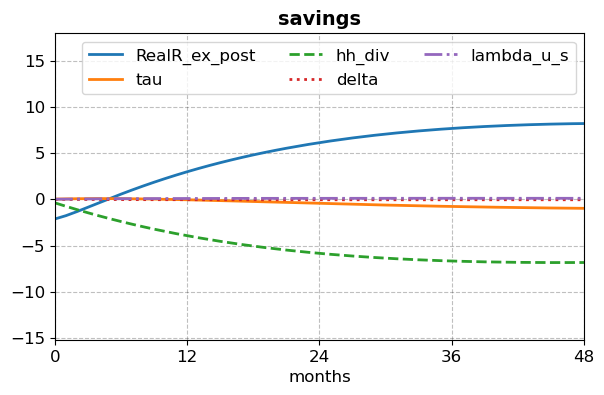

In [8]:
lss = ['-','-','--',':','-.',]

fig,ax = create_fig()
for input,ls in zip(all_inputs,lss):
    ax.plot((path_GE[input].A_hh/model.ss.A_hh-1)*100,lw=2,ls=ls,label=input)

save_fig(fig,ax,
        filename='GE_decompo_A_hh',
        title='savings',
        ylabel='',legend=True)

ax.legend(ncol=3)
ylim = ax.get_ylim()
ax.set_ylim([2*y for y in ylim]);

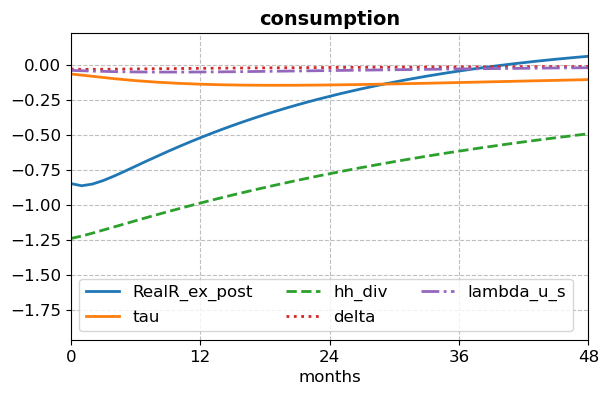

In [9]:
fig,ax = create_fig()
for input,ls in zip(all_inputs,lss):
    ax.plot((path_GE[input].C_hh/model.ss.C_hh-1)*100,lw=2,ls=ls,label=input)

save_fig(fig,ax,
        filename='GE_decompo_C_hh',
        title='consumption',
        ylabel='',legend=True)

ax.legend(ncol=3)
ylim = ax.get_ylim()
ax.set_ylim([ylim[0]*1.5,ylim[1]]);

## 4. <a id='toc4_'></a>[PE analysis](#toc0_)

### 4.1. <a id='toc4_1_'></a>[$\beta$ heterogeneity](#toc0_)

In [10]:
model_het = model.copy()

beta_grid = np.array([0.88,0.91,0.94,0.96,0.97,0.975])**(1/12)
    
path_het = {}
ss_het = {}
for beta in beta_grid:

    model_het.par.beta_grid[:] = beta

    model_het.solve_hh_ss()
    model_het.simulate_hh_ss()

    print(f'{beta**12 = :.2f}, {model_het.ss.A_hh = :.3f}')

    path_het[beta] = model_het.decompose_hh_path(do_print=False,use_inputs=['lambda_u_s','delta'])
    ss_het[beta] = deepcopy(model_het.ss)

beta**12 = 0.88, model_het.ss.A_hh = 0.139


beta**12 = 0.91, model_het.ss.A_hh = 0.254


beta**12 = 0.94, model_het.ss.A_hh = 0.513


beta**12 = 0.96, model_het.ss.A_hh = 0.941


beta**12 = 0.97, model_het.ss.A_hh = 1.478


beta**12 = 0.97, model_het.ss.A_hh = 2.120


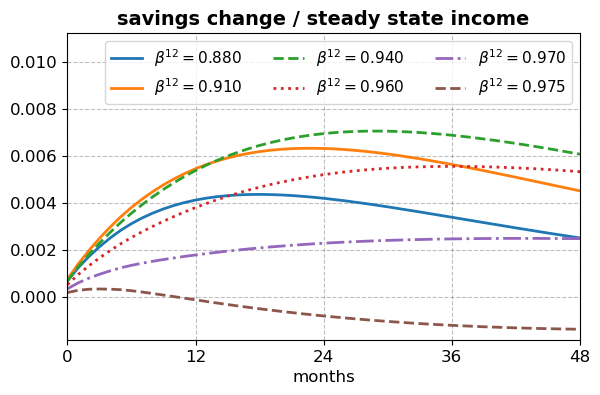

In [11]:
lss = ['-','-','--',':','-.','--']
fig,ax = create_fig()
for beta,ls in zip(beta_grid,lss):
    ax.plot((path_het[beta].A_hh-ss_het[beta].A_hh)/model.ss.Yt_hh,ls=ls,lw=2,label=f'$\\beta^{{12}} = {beta**12:.3f}$')

ax.legend(ncol=3,fontsize=11)
ylim = ax.get_ylim()
ax.set_ylim([ylim[0],ylim[1]*1.5])

save_fig(fig,ax,
        filename='PE_beta_het_A_hh_add',
        title='savings change / steady state income',
        ylabel='')

### 4.2. <a id='toc4_2_'></a>[Preliminaries](#toc0_)

In [12]:
delta_full_UE = np.zeros(par.T)
lambda_u_s_full_UE = np.zeros(par.T)
   
delta_full_UE[:] = model.ss.delta
    
u = model.path.u[:,0]
    
for t in range(par.T):
    u_lag = model.path.u[t-1] if t > 0 else ss.u
    lambda_u_s_full_UE[t] = (u_lag - model.path.u[t] + delta_full_UE[t]*(1-u_lag))/u_lag 

        

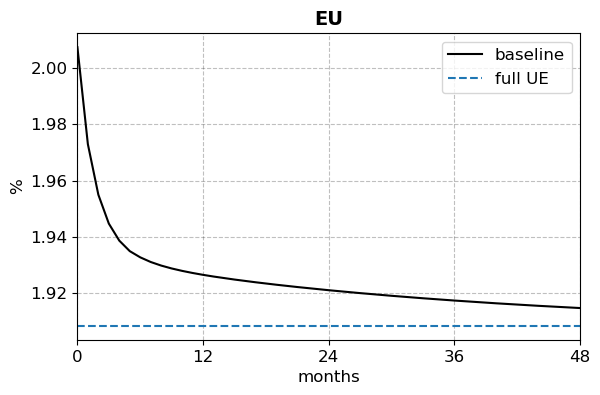

In [13]:
fig,ax = create_fig()

ax.plot(model.path.delta*100,color='black',label=f'baseline')
ax.plot(delta_full_UE*100,ls='--',label=f'full UE')

save_fig(fig,ax,
         filename='PE_delta_full_EU',
         title='EU',
         ylabel='%',legend=True)

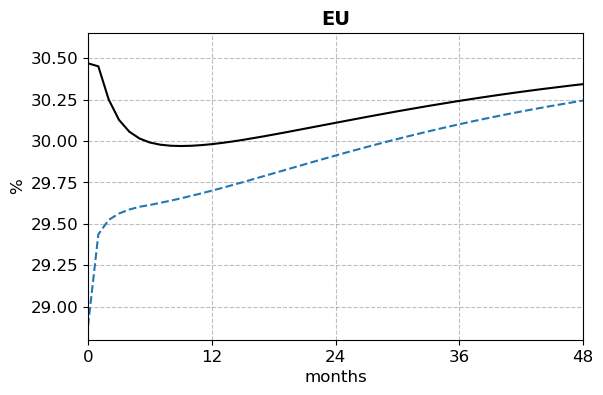

In [14]:
fig,ax = create_fig()

ax.plot(model.path.lambda_u*100,color='black',label=f'baseline')
ax.plot(lambda_u_s_full_UE*100,ls='--',label=f'full UE')

save_fig(fig,ax,
         filename='PE_lambda_u_full_EU',
         title='EU',
         ylabel='%',legend=False)

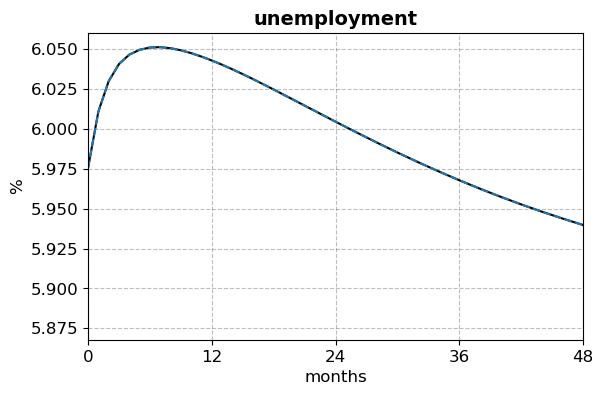

In [15]:
fig,ax = create_fig()

ax.plot(model.path.u*100,color='black',label=f'baseline')
ax.plot(u*100,ls='--',label=f'full UE')

save_fig(fig,ax,
         filename='PE_u_full_EU',
         title='unemployment',
         ylabel='%',legend=False)

### 4.3. <a id='toc4_3_'></a>[Run general decompositions](#toc0_)

In [16]:
def add_rel_to_ss(path,ss):
    
    path.dA_hh = (path.A_hh[:,0]/ss.A_hh-1)*100
    path.dC_hh = (path.C_hh[:,0]/ss.C_hh-1)*100
    
    path.du = (np.sum(path.D[:,:,1:,:],axis=(1,2,3))-ss.u)*100

In [17]:
def get_equivalent_w(path,ss):
             
    U_UI_hh = path.U_UI_hh[:,0]
    u = path.u[:,0]
    phi_obar = path.phi_obar[:,0]

    term_a = (1-u)+phi_obar*U_UI_hh+par.phi_ubar*(u-U_UI_hh)
    term_b = (1-ss.u)+ss.phi_obar*ss.U_UI_hh+par.phi_ubar*(ss.u-ss.U_UI_hh)
    w = ss.w*term_a/term_b
    
    # check
    UI = phi_obar*w*U_UI_hh + par.phi_ubar*w*(u-U_UI_hh)
    Yt_hh = w*(1-u) + UI
    diff_Yt_hh = path.Yt_hh[:,0] - Yt_hh
    np.allclose(diff_Yt_hh,0.0)

    return w

In [18]:
paths = {}
for use_inputs,fix_z_trans,full_UE in [
    (('lambda_u_s','delta'),False,False),
    (('delta',),False,False),
    (('lambda_u_s',),False,False),
    (('w',),False,False),
    (('lambda_u_s','delta'),True,False),
    (('lambda_u_s','delta'),True,True),
    ]:

    key = (model.name,use_inputs,fix_z_trans,full_UE)

    print(key)

    custom_paths = {}
    for inputname in use_inputs:
        
        if inputname == 'w':
            assert not full_UE
            custom_paths['w'] = get_equivalent_w(model.path,ss)
        else:
            if full_UE and inputname in ['delta','lambda_u_s']:
                if inputname == 'delta':
                    custom_paths[inputname] = delta_full_UE
                elif inputname == 'lambda_u_s':
                    custom_paths[inputname] = lambda_u_s_full_UE
            else:
                custom_paths[inputname] = model.path.__dict__[inputname][:,0]

    path = paths[key] = model.decompose_hh_path(do_print=False,
        use_inputs=use_inputs,custom_paths=custom_paths,fix_z_trans=fix_z_trans)         

    add_rel_to_ss(path,model.ss)        

('baseline', ('lambda_u_s', 'delta'), False, False)


('baseline', ('delta',), False, False)


('baseline', ('lambda_u_s',), False, False)


('baseline', ('w',), False, False)


('baseline', ('lambda_u_s', 'delta'), True, False)


('baseline', ('lambda_u_s', 'delta'), True, True)


### 4.4. <a id='toc4_4_'></a>[Only behavior](#toc0_)

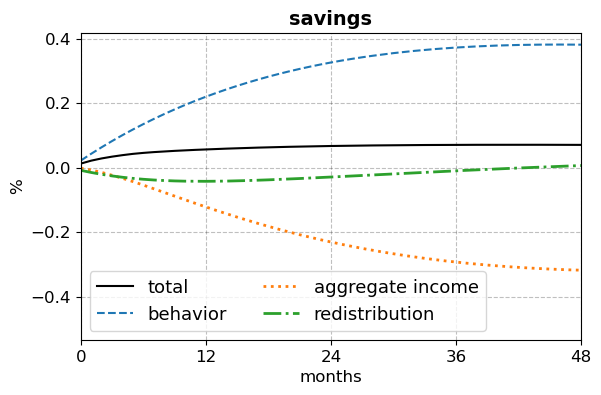

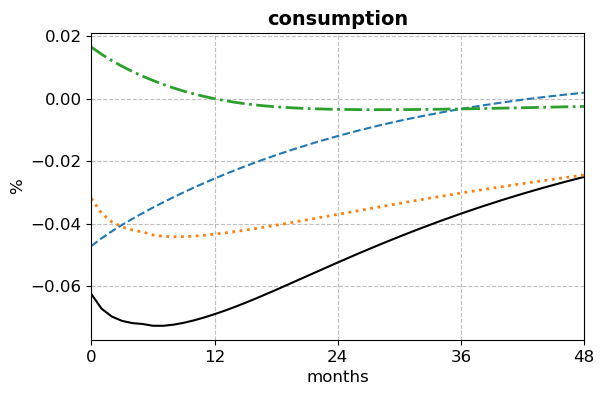

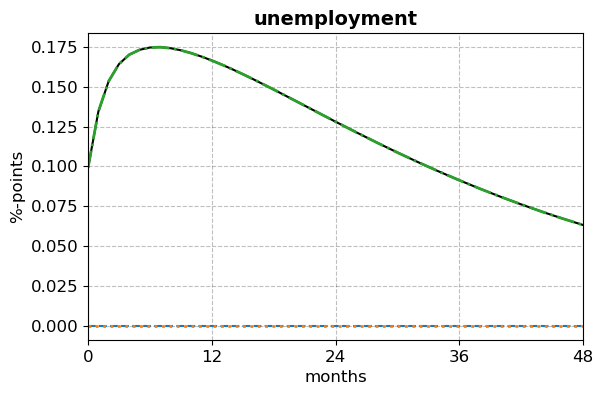

In [19]:
for varname,title in [('dA_hh','savings'),('dC_hh','consumption'),('du','unemployment')]:

    fig,ax = create_fig()
    
    path_tot = paths[(model.name,('lambda_u_s','delta'),False,False)]
    ax.plot(path_tot.__dict__[varname],label='total',color='black', ls='-')

    path_beh = paths[(model.name,('lambda_u_s','delta'),True,False)]
    ax.plot(path_beh.__dict__[varname],label='behavior',ls='--')

    path_inc = paths[(model.name,('w',),False,False)]
    ax.plot(path_inc.__dict__[varname],label='aggregate income',ls=':',lw=2)

    y = path_tot.__dict__[varname] - path_beh.__dict__[varname] - path_inc.__dict__[varname]
    ax.plot(y,label='redistribution',ls='-.',lw=2)

    if varname == 'dA_hh': 
        ax.legend(frameon=True,ncol=2,fontsize=13)
        ylim = ax.get_ylim()
        ax.set_ylim([ylim[0]*1.5,ylim[1]])

    if varname in ['dC_hh','dY_hh']:
        ylabel='%'
    elif varname in ['dA_hh']:        
        ylabel='%'
    elif varname in ['du']:
        ylabel='%-points'

    save_fig(fig,ax,f'PE_{varname}_behavior',title=title,ylabel=ylabel)
   
    plt.show()


### 4.5. <a id='toc4_5_'></a>[Employed vs unemployed + EU vs. UE](#toc0_)

In [20]:
def add_only_employed(key):

    # a. full behavior
    path_ = paths[key]

    # b. behavior of only employed
    model_ = model.copy()

    model_.path.a = path_.a.copy()
    model_.path.c = path_.c.copy()
    model_.path.a[:,:,1:,:] = model.ss.a[:,1:,:] # neutralize unemployed
    model_.path.c[:,:,1:,:] = model.ss.c[:,1:,:] # neutralize unemployed
    model_.path.z_trans[:] = model.ss.z_trans # neutralize transitions

    model_._find_i_and_w_path() # find indices and weights

    # c. simulate
    model_.simulate_hh_path()
    add_rel_to_ss(model_.path,model_.ss)

    paths[(*key,'employed')] = model_.path


In [21]:
add_only_employed((model.name,('lambda_u_s','delta'),True,False))

In [22]:
add_only_employed((model.name,('lambda_u_s','delta'),True,True))

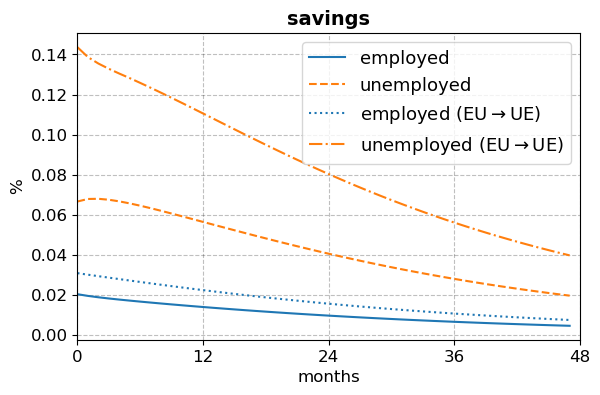

In [23]:
fig,ax = create_fig()

path_ = paths[((model.name,('lambda_u_s','delta'),True,False))]

# a. baseline
A_hh_e_ss = np.sum(ss.a[:,0,:]*ss.D[:,0,:])/np.sum(ss.D[:,0,:]) 
A_hh_e = [np.sum(path_.a[t,:,0,:]*ss.D[:,0,:])/np.sum(ss.D[:,0,:]) for t in range(par.T)]
ax_e = ax.plot(100*(A_hh_e[:48]/A_hh_e_ss-1),label='employed',ls='-') 

A_hh_u_ss = np.sum(ss.a[:,1:,:]*ss.D[:,1:,:])/np.sum(ss.D[:,1:,:]) 
A_hh_u = [np.sum(path_.a[t,:,1:,:]*ss.D[:,1:,:])/np.sum(ss.D[:,1:,:]) for t in range(par.T)]
ax_u = ax.plot(100*(A_hh_u[:48]/A_hh_u_ss-1),label='unemployed',ls='--') 

path_ = paths[((model.name,('lambda_u_s','delta'),True,True))]

A_hh_e_ss = np.sum(ss.a[:,0,:]*ss.D[:,0,:])/np.sum(ss.D[:,0,:]) 
A_hh_e = [np.sum(path_.a[t,:,0,:]*ss.D[:,0,:])/np.sum(ss.D[:,0,:]) for t in range(par.T)]
ax.plot(100*(A_hh_e[:48]/A_hh_e_ss-1),color=ax_e[0].get_color(),label='employed (EU$\\rightarrow$UE)',ls=':') 

A_hh_u_ss = np.sum(ss.a[:,1:,:]*ss.D[:,1:,:])/np.sum(ss.D[:,1:,:]) 
A_hh_u = [np.sum(path_.a[t,:,1:,:]*ss.D[:,1:,:])/np.sum(ss.D[:,1:,:]) for t in range(par.T)]
ax.plot(100*(A_hh_u[:48]/A_hh_u_ss-1),color=ax_u[0].get_color(),label='unemployed (EU$\\rightarrow$UE)',ls='-.') 

ax.legend(frameon=True,ncol=1,fontsize=13)

save_fig(fig,ax,f'PE_dA_hh_fixed_dist',title='savings',ylabel='%')
plt.show()


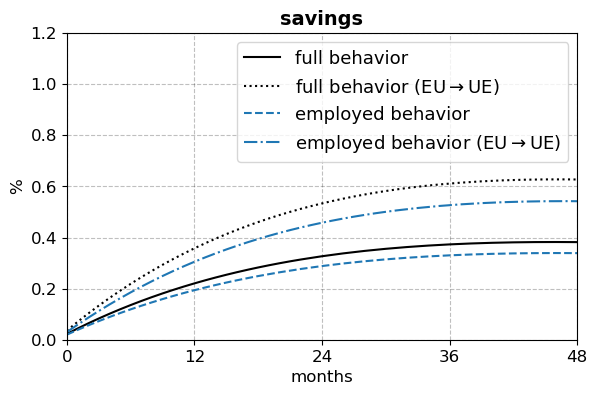

In [24]:
for varname,title in [('dA_hh','savings')]:

    fig,ax = create_fig()

    path_ = paths[((model.name,('lambda_u_s','delta'),True,False))]
    ax.plot(path_.__dict__[varname],label='full behavior',color='black',ls='-')

    path_ = paths[((model.name,('lambda_u_s','delta'),True,True))]
    ax.plot(path_.__dict__[varname],label='full behavior (EU$\\rightarrow$UE)',color='black',ls=':')   

    path_ = paths[((model.name,('lambda_u_s','delta'),True,False,'employed'))]
    ax_ = ax.plot(path_.__dict__[varname],label='employed behavior',ls='--')
    
    path_ = paths[((model.name,('lambda_u_s','delta'),True,True,'employed'))]
    ax.plot(path_.__dict__[varname],label='employed behavior (EU$\\rightarrow$UE)',color=ax_[0].get_color(),ls='-.')    

    if varname == 'dA_hh': ax.legend(frameon=True,ncol=1,fontsize=13)

    ax.set_ylim([0.0,1.2])
    save_fig(fig,ax,f'PE_{varname}_behavior_employed',title=title,ylabel='%')
    plt.show()
    